In [2]:
%matplotlib ipympl
import os
import os.path as path
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from faker import Factory
from scipy import interpolate
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import math 
import itertools 
from ipywidgets import interact, interactive, fixed, interact_manual, widgets
from ipywidgets import HBox, VBox
from ipywidgets import IntSlider, Output
from IPython.display import clear_output
import h5py
import re
import matplotlib
import ipysheet

# Local module and scripts
from pyccapt.calibration.calibration_tools import tools, variables, calibration, ion_selection
from pyccapt.calibration.calibration_tools import widgets as wd
from pyccapt.calibration.data_tools import data_tools, data_loadcrop, dataset_path_qt
from pyccapt.calibration.mc import mc_tools
from pyccapt.calibration.leap_tools import ccapt_tools

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%reload_ext autoreload

In [5]:
# Disable showing logging in Jupyter notebook
import logging, sys
logging.disable(sys.maxsize)

In [6]:
button = widgets.Button(
    description='load dataset',
)

@button.on_click
def open_file_on_click(b):
    global dataset_path
    dataset_path = dataset_path_qt.gui_fname().decode('ASCII')
button

Button(description='load dataset', style=ButtonStyle())

In [7]:
tdc, pulse_mode, flightPathLength_d, t0_d, max_mc, det_diam = wd.dataset_tdc_selection()
display(tdc)

Dropdown(description='Data mode:', options=('surface_concept', 'roentdec', 'leap_epos', 'leap_pos'), value='su…

$$\textbf{You can specify which dataset to use in below block}$$

In [8]:
dataset_main_path = os.path.dirname(dataset_path)
dataset_name_with_extention = os.path.basename(dataset_path)
dataset_name = os.path.splitext(dataset_name_with_extention)[0]


variables.init()
# variables.path = os.path.join(p, 'tests//data')
variables.result_path = os.path.dirname(dataset_main_path) + '/ion_selection_ranging/'
if not os.path.isdir(variables.result_path):
    os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
        
filename = dataset_path

head, tail = os.path.split(filename)
figname = os.path.splitext(tail)[0]

if tdc.value == 'leap_pos' or tdc.value == 'leap_epos':
    if tdc.value == 'leap_epos':
        data = ccapt_tools.epos_to_ccapt(filename)
    else:
        data = ccapt_tools.pos_to_ccapt(filename)
else:
    data = data_tools.read_hdf5_through_pandas(filename)

In [9]:
data

,x (nm),y (nm),z (nm),mc_c (Da),mc (Da),high_voltage (V),pulse (V),start_counter,t (ns),t_c (nm),x_det (cm),y_det (cm),pulse_pi,ion_pp,tof_c (ns),t_c (ns)
0,0.0,0.0,0.0,27.370268,27.401002,5269.834473,5269.834473,54436.0,635.421132,0.0,-1.595020,-1.661878,0,1,632.329093,632.329093
1,0.0,0.0,0.0,27.255572,27.522766,5269.834473,5269.834473,54903.0,635.901192,0.0,0.646286,2.129878,467,1,631.150808,631.150808
2,0.0,0.0,0.0,27.125602,27.582728,5269.834473,5269.834473,55353.0,648.101574,0.0,-0.175102,3.155020,450,1,629.812492,629.812492
3,0.0,0.0,0.0,27.305339,26.913047,5269.834473,5269.834473,55831.0,636.010920,0.0,1.964327,-1.999347,478,1,631.662383,631.662383
4,0.0,0.0,0.0,27.156364,27.273478,5269.834473,5269.834473,56022.0,633.350016,0.0,1.381714,1.757388,191,1,630.129557,630.129557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1898626,0.0,0.0,0.0,261.370558,248.363850,5711.471680,5711.471680,37587.0,1716.831720,0.0,0.369306,-1.330776,83,1,1791.799564,1791.799564
1898627,0.0,0.0,0.0,26.897229,27.320343,5711.471680,5711.471680,38162.0,600.993972,0.0,0.423429,0.630367,575,1,627.452830,627.452830
1898628,0.0,0.0,0.0,27.537022,27.881308,5711.471680,5711.471680,38200.0,606.096324,0.0,0.560327,0.200571,38,1,634.037621,634.037621
1898629,0.0,0.0,0.0,26.882814,27.072135,5711.471680,5711.471680,38467.0,600.026994,0.0,0.926449,-0.633551,267,1,627.303543,627.303543


In [10]:
variables.mc_calib = data['mc_c (Da)'].to_numpy()
cc = data['mc_c (Da)'].to_numpy()

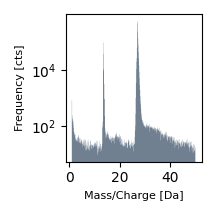

In [24]:
peaks_ini, peaks_y_ini, peak_widths_p_ini, mask = tools.hist_plot(cc[cc < 50], 0.1, distance=10, percent=50, prominence=50, selector='peak', plot=True, label='mc', peaks_find=True, fig_size=(5.5/2.54, 5.5/2.54), fig_name='mc')

In [15]:
bin_size=widgets.FloatText(value=0.1, description='bin size:')
prominence=widgets.IntText(value=60, description='peak prominance:')
distance=widgets.IntText(value=50, description='peak distance:')
lim_tof=widgets.IntText(value=150, description='lim tof/mc:')
percent=widgets.IntText(value=90, description='percent MRP:')

def hist_plot(figname, plot):
    variables.peaks_idx = []
    peaks_sides_p = np.zeros(0)
    with out:
        clear_output(True)

        bin_size_p = bin_size.value
        prominence_p = prominence.value
        distance_p = distance.value
        lim_tof_p = lim_tof.value
        percent_p = percent.value
        peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(variables.mc_calib[variables.mc_calib < lim_tof_p], bin_size_p, distance=distance_p, percent=percent_p, prominence=prominence_p, selector='peak', plot=plot, label='mc', fig_name=figname)
        index_max_ini = np.argmax(peaks_y_ini)
        variables.max_peak = peaks_ini[index_max_ini]
        variables.peak = peaks_ini
        variables.peak_y
        variables.peak_width = peak_widths_p_ini
        mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
        print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
        for i in range(len(peaks_ini)):
            print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides (half-maximum) are: ({:.2f}, {:.2f})'.format(peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

In [16]:
peak_val = widgets.FloatText(value=1.1, description='peak value:')
charge = widgets.Dropdown(
    options=[('1', 1), ('2', 2), ('3', 3), ('4', 4)],
    value=3,
    description='charge:'
)
aboundance_threshold = widgets.FloatText(value=1, description='aboundance threshold:')
mode = widgets.Dropdown(
    options=[('elements', 'elements'), ('molecules', 'molecules')],
    value='elements',
    description='mode:'
)

num_element = widgets.IntText(value=1, description='num element:')
# element_threshold = widgets.FloatText(value=1.0, description='Aboundance threshold:')

def element_finder():
    with out:
        peak_val_s = peak_val.value
        charge_s = charge.value
        num_element_s = num_element.value
#         num_molecule_s = num_molecule.value
        mode_s = mode.value
#         element_threshold_s = element_threshold.value
        aboundance_threshold_s = aboundance_threshold.value
        clear_output(True)
        if mode_s == 'elements':
            df = ion_selection.find_close_element(peak_val_s, num_element_s, aboundance_threshold_s, charge=charge_s)
        elif mode_s == 'molecules':
            df = ion_selection.find_close_molecule(peak_val_s, num_element_s, aboundance_threshold_s, charge=charge_s)
        display(df)

In [17]:
isotope_formula = widgets.Text(
    value='',
    placeholder='Type a formula',
    description='Isotope formula:',
    disabled=False
)

def manual_formula_calculator():
    isotopeTableFile = '../../../files/isotopeTable.h5'
    dataframe = data_tools.read_hdf5_through_pandas(isotopeTableFile)
    df = ion_selection.molecule_isotop_list(dataframe, isotope_formula.value)
    with out:
        df = ion_selection.molecule_isotop_list(dataframe, isotope_formula.value)
        clear_output(True)
        display(df)

In [18]:
isotopeTableFile = '../../../files/isotopeTable.h5'
dataframe = data_tools.read_hdf5_through_pandas(isotopeTableFile)
elementsList = dataframe['element']
elementIsotopeList = dataframe['isotope']
elementMassList =  dataframe['weight']
abundanceList = dataframe['abundance']
dropdownDict = {'element': elementsList, 'isotope': elementIsotopeList}

elements = list(zip(elementsList, elementIsotopeList, elementMassList, abundanceList))
dropdownList = []
for element in elements:
    tupleElement = ("{} ({}) ({:.2f})".format(element[0],element[1],element[3]), "{}({})".format(element[0], element[1]))
    dropdownList.append(tupleElement)

dropdown = wd.dropdownWidget(dropdownList, "Elements")
dropdown.observe(wd.on_change_ions_selection)

chargeList = [(1,1,),(2,2,),(3,3,),(4,4,)]
chargeDropdown = wd.dropdownWidget(chargeList, "Charge")
chargeDropdown.observe(wd.on_change_charge_ions_selection)

# wd.compute_element_isotope_values_according_to_selected_charge(mode='ions_selection')

buttonAdd = wd.buttonWidget("ADD")
buttonDelete = wd.buttonWidget("DELETE")
buttonReset = wd.buttonWidget("RESET")

def buttonAdd_f(b,):
    with out:
        clear_output(True)
        wd.onClickAdd(b,)
        display()
def buttonDelete_f(b,):
    with out:
        clear_output(True)
        variables.listMaterial.pop()
        variables.element.pop()
        variables.isotope.pop()
        variables.charge.pop()
        print("Updated List : ", variables.listMaterial)
        print("Updated element List : ", variables.element)
        print("Updated isotope List : ",  variables.isotope)
        print("Updated charge List : ", variables.charge)
def buttonResett_f(b,):
    with out:
        clear_output(True)
        wd.onClickReset(b,)
        display()

buttonAdd.on_click(buttonAdd_f)
buttonDelete.on_click(buttonDelete_f)
buttonReset.on_click(buttonResett_f)

add_button = widgets.Button(
    description='add molecule',
)

peak_molecule = widgets.Text(
    value='',
    placeholder='molecule: H(1)2O(16)(2+)',
    description='molecule:',
    disabled=False
)
peak_molecule_elements = widgets.Text(
    value='',
    placeholder='elements: H,O',
    description='elements:',
    disabled=False
)
peak_molecule_isotope = widgets.Text(
    value='',
    placeholder='isotope: 1,16',
    description='isotope:',
    disabled=False
)
peak_molecule_charge = widgets.IntText(
    placeholder='charge: 3',
    description='charge:',
    disabled=False
)

@add_button.on_click
def add_molucule_to(b,):
    with out:
        clear_output(True)
        if peak_molecule.value == 'unranged':
            variables.listMaterial.append(peak_molecule.value)
            variables.element.append(peak_molecule.value)
            variables.isotope.append(0)
            variables.charge.append(0)
        else:
            variables.listMaterial.append(peak_molecule.value)
            variables.element.append(peak_molecule_elements.value.split(','))
            variables.isotope.append(peak_molecule_isotope.value.split(','))
            variables.charge.append(peak_molecule_charge.value)
        print("Updated List : ", variables.listMaterial)
        print("Updated element List : ", variables.element)
        print("Updated isotope List : ",  variables.isotope)
        print("Updated charge List : ", variables.charge)

In [19]:
plot_button = widgets.Button(
    description='plot hist',
)

find_button = widgets.Button(
    description='find element',
)

formula_find_button = widgets.Button(
    description='molecule calculate',
)

    
@plot_button.on_click
def plot_on_click(b, figname=figname, plot=True):
    hist_plot(figname, plot)

    
@find_button.on_click
def vol_on_click(b,):
    element_finder()
    
@formula_find_button.on_click
def manual_formula(b,):
    manual_formula_calculator()
    
tab1 = VBox(children=[bin_size, prominence, distance, lim_tof, percent])
tab2 = HBox(children=[VBox(children=[peak_val, num_element, charge, aboundance_threshold, mode, 
                      find_button]),HBox(children=[isotope_formula, formula_find_button])])
tab3 = VBox(children=[dropdown, chargeDropdown, buttonAdd, buttonDelete, buttonReset])
tab4 = VBox(children=[peak_molecule, peak_molecule_elements, peak_molecule_isotope, peak_molecule_charge, add_button])


tab = widgets.Tab(children=[tab1, tab2, tab3, tab4])
tab.set_title(0, 'mc plot')
tab.set_title(1, 'element finder')
tab.set_title(2, 'add ions')
tab.set_title(3, 'add molecules')


display(VBox(children=[tab,HBox(children=[plot_button])]))
out = Output()
display(out)
# unranged	

Output()

In [23]:
fake = Factory.create()
data_table = '../../../files/color_scheme.h5'
dataframe = data_tools.read_hdf5_through_pandas(data_table)
color_list = []
for i in range(len(variables.listMaterial)):
    element_selec = re.sub("[\(\[].*?[\)\]]", "", variables.listMaterial[i])
    if len(re.findall(r'[A-Z]', element_selec)) > 1:
        try:
            r = dataframe[dataframe['ion'] == re.sub(r'[0-9]', '', element_selec)]['r'].to_numpy()
            g = dataframe[dataframe['ion'] == re.sub(r'[0-9]', '', element_selec)]['g'].to_numpy()
            b = dataframe[dataframe['ion'] == re.sub(r'[0-9]', '', element_selec)]['b'].to_numpy()
            cc = matplotlib.colors.to_hex([r[0], g[0], b[0]])
            color_list.append(cc)
        except:
            print('The element is not clor list')
            color_list.append(fake.hex_color())
    else:
        try:
            r = dataframe[dataframe['ion'] == re.sub(r'[0-9]', '', element_selec)]['r'].to_numpy()
            g = dataframe[dataframe['ion'] == re.sub(r'[0-9]', '', element_selec)]['g'].to_numpy()
            b = dataframe[dataframe['ion'] == re.sub(r'[0-9]', '', element_selec)]['b'].to_numpy()
            cc = matplotlib.colors.to_hex([r[0], g[0], b[0]])
            color_list.append(cc)
        except:
            print('The element is not clor list')
            color_list.append(fake.hex_color())

In [24]:
peak_width_chos = []
for i in range(len(variables.peaks_idx)):
    peak_width_chos.append(variables.peak_width[variables.peaks_idx[i]])
peak_width_chos = np.array(peak_width_chos)

In [25]:
range_data = pd.DataFrame({"element": variables.element, "isotope": variables.isotope, "charge": variables.charge,
        "mc_low": [item[1] for item in peak_width_chos],
       "mc_up": [item[2] for item in peak_width_chos],"color": color_list})

In [43]:
sheet7 = ipysheet.from_dataframe(range_data)
sheet7

Sheet(cells=(Cell(column_end=0, column_start=0, numeric_format=None, row_end=2, row_start=0, squeeze_row=False…

In [49]:
range_data = ipysheet.to_dataframe(sheet7)
range_data

,element,isotope,charge,mc_low,mc_up,color
0,H,1,1,1.191262,1.289001,#FF3500
1,Al,27,2,13.310880,13.604096,#39FF14
2,Al,27,3,26.798841,27.287536,#39FF14


In [50]:
def mc_hist_plot(data, range_data, bin_size, prominence, distance, percent, selector, plot, figname, lim_mc, mc_peak_label, ranging, adjust_label):
    mc = data['mc_c (Da)'].to_numpy()
    peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(mc[mc < lim_mc], bin_size, range_data=range_data, mc_peak_label=mc_peak_label, ranging=ranging, adjust_label=adjust_label, distance=distance, percent=percent, prominence=prominence, selector=selector, plot=plot, label='mc', fig_name=figname+'_ini')
    index_max_ini = np.argmax(peaks_y_ini)
    variables.max_peak = peaks_ini[index_max_ini]
    variables.peak = peaks_ini
    mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
    print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
    for i in range(len(peaks_ini)):
        print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides (half-maximum) are: ({:.2f}, {:.2f})'.format(peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

interact_manual(mc_hist_plot, data=fixed(data), range_data=fixed(range_data), bin_size=widgets.FloatText(value=0.1)
               ,prominence=widgets.IntText(value=50), distance=widgets.IntText(value=100), lim_mc=widgets.IntText(value=150)
               ,percent=widgets.IntText(value=50), selector=fixed('rect'), plot=fixed(True), figname=fixed(figname),
               mc_peak_label=widgets.Dropdown(options=[('True', True), ('False', False)]),
                ranging=widgets.Dropdown(options=[('True', True), ('False', False)]),
                adjust_label=widgets.Dropdown(options=[('True', True), ('False', False)]));


interactive(children=(FloatText(value=0.1, description='bin_size'), IntText(value=50, description='prominence'…

In [51]:
range_data

,element,isotope,charge,mc_low,mc_up,color
0,H,1,1,1.191262,1.289001,#FF3500
1,Al,27,2,13.310880,13.604096,#39FF14
2,Al,27,3,26.798841,27.287536,#39FF14


In [52]:
range_data.dtypes

element     object
isotope      int32
charge       int32
mc_low     float64
mc_up      float64
color       object
dtype: object

In [53]:
# save the new data
name_save_file = variables.result_path + '//' + dataset_name + '.h5'
data_tools.store_df_to_hdf(name_save_file, range_data, 'df')

In [54]:
# save data in csv format
data_tools.store_df_to_csv(range_data, variables.result_path + 'range_' + dataset_name + '.csv')